In [1]:
#import necessary packages and libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, Add
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import gensim
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('punkt')
import re
import codecs
import matplotlib.pyplot as plt
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\z\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df_train = pd.read_csv('dataset/cleaned_30kundersampling.csv')
df_test = pd.read_csv('dataset/test_cleaned_14k.csv')

In [88]:
# df = pd.read_csv('severe_toxic_predict.csv')
# df.head()

,id,cleaned_text,comment_text,severe_toxic
0,9bf33f071c9b3263,charge happy catch,""" \n : ) No charge. Happy I was there to catch...",0
1,39663d63a79f841b,thanks clean wp wa issue,==Thanks== \n For cleaning up the wp in wa issue!,0
2,2b8aa65b64094d44,people keen act upon whim put spoiler rather s...,Why are people keen to act upon their whims an...,0
3,b21145e7025ea830,artist fake person shallow heartless quick tur...,This Artist is FAKE! \n\n * \n\n https://www...,0
4,4c24b0fa5c3e0db0,come talk page hey bb come talk page redrafted...,""" \n\n == Come by the Talk Page == \n\n Hey Bb...",0


In [18]:
count = (df_train['toxic'] == 0).sum()
print("toxic count: " ,count)

count1 = (df_train['severe_toxic'] == 1).sum()
print("severe-toxic count: " ,count1)

toxic count:  15289
severe-toxic count:  1595


In [3]:
df_train.head()

,Unnamed: 0,id,comment_text,severe_toxic,toxic,cleaned_text,count
0,0,c436fcdd4acc928a,naw i am fine see you later guys you rock ) ha...,0,0,nope fine see later guy rock hahahahaha userbi...,44
1,1,17bb9f8b0e2ff008,LOL\n\nREDDIT PWN YOU LMAO. UnknownTales1,0,0,lol reddit pwn lmao unknowntales,28
2,2,e86ae38d7ff0c1ff,You jumped the gun a bit too early - that's my...,0,0,jump gun bit early first revert hour,30
3,3,cb1fcb465bd93930,"No way, Mercedez PWNZ!!",0,0,way mercedez pwnz,15
4,4,140cb8dc1570e423,I noticed it doesn't mention if the real Presi...,0,0,notice mention real president shot,30


In [4]:
df_train = df_train.drop(['Unnamed: 0','comment_text',"count"], axis=1)
df_train

,id,severe_toxic,toxic,cleaned_text
0,c436fcdd4acc928a,0,0,nope fine see later guy rock hahahahaha userbi...
1,17bb9f8b0e2ff008,0,0,lol reddit pwn lmao unknowntales
2,e86ae38d7ff0c1ff,0,0,jump gun bit early first revert hour
3,cb1fcb465bd93930,0,0,way mercedez pwnz
4,140cb8dc1570e423,0,0,notice mention real president shot
...,...,...,...,...
30583,fef4cf7ba0012866,0,1,previous conversation fuck shit eating liberal...
30584,ff39a2895fc3b40e,0,1,mischievious pubic hair
30585,ffa33d3122b599d6,0,1,absurd edits absurd edit great white shark tot...
30586,ffb47123b2d82762,0,1,hey listen ever delete edits ever annoy wwe k ...


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30588 entries, 0 to 30587
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30588 non-null  object
 1   severe_toxic  30588 non-null  int64 
 2   toxic         30588 non-null  int64 
 3   cleaned_text  30583 non-null  object
dtypes: int64(2), object(2)
memory usage: 956.0+ KB


In [6]:
df_train.isnull().sum()

id              0
severe_toxic    0
toxic           0
cleaned_text    5
dtype: int64

In [7]:
df_test.isnull().sum()

id                0
comment_text      0
cleaned_text    101
count             0
dtype: int64

In [8]:
df_train.dropna(subset = ["cleaned_text"], inplace=True)
df_train.head()

,id,severe_toxic,toxic,cleaned_text
0,c436fcdd4acc928a,0,0,nope fine see later guy rock hahahahaha userbi...
1,17bb9f8b0e2ff008,0,0,lol reddit pwn lmao unknowntales
2,e86ae38d7ff0c1ff,0,0,jump gun bit early first revert hour
3,cb1fcb465bd93930,0,0,way mercedez pwnz
4,140cb8dc1570e423,0,0,notice mention real president shot


In [9]:
df_test.dropna(subset = ["cleaned_text"], inplace=True)
df_test.head()

,id,comment_text,cleaned_text,count
0,9bf33f071c9b3263,""" \n : ) No charge. Happy I was there to catch...",charge happy catch,16
1,39663d63a79f841b,==Thanks== \n For cleaning up the wp in wa issue!,thanks clean wp wa issue,20
2,2b8aa65b64094d44,Why are people keen to act upon their whims an...,people keen act upon whim put spoiler rather s...,283
3,b21145e7025ea830,This Artist is FAKE! \n\n * \n\n https://www...,artist fake person shallow heartless quick tur...,226
4,4c24b0fa5c3e0db0,""" \n\n == Come by the Talk Page == \n\n Hey Bb...",come talk page hey bb come talk page redrafted...,159


In [149]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30583 entries, 0 to 30587
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30583 non-null  object
 1   severe_toxic  30583 non-null  int64 
 2   toxic         30583 non-null  int64 
 3   cleaned_text  30583 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.2+ MB


In [48]:
# preprocessing

In [10]:
#Clean the datsets by removing special characters, numbers etc.
def news_wordlist(new, remove_stopwords=False):
    new = re.sub("[^a-zA-Z]"," ", new)
    words = new.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))     
        words = [w for w in words if not w in stops] 
    return (words)

In [11]:
#define function to return news after cleaning
def news_sentences(new, remove_stopwords=False):
    raw_sentences = nltk.sent_tokenize(new.strip())
    sentences = []
    # 2. Loop for each sentence
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(news_wordlist(raw_sentence, remove_stopwords))

    # This returns the list of lists
    return sentences

sentences = []

for new in df_train["cleaned_text"]:
    sentences += news_sentences(new)

In [12]:
#Add each word in the combined column of news datset into vocab list
from collections import Counter
vocab = Counter()

for new in df_train["cleaned_text"]:
    raw_sentences = nltk.sent_tokenize(new.strip())
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            vocab.update(news_wordlist(raw_sentence, remove_stopwords=False))

In [13]:
sentences

[['nope',
  'fine',
  'see',
  'later',
  'guy',
  'rock',
  'hahahahaha',
  'userbig',
  'foot'],
 ['lol', 'reddit', 'pwn', 'lmao', 'unknowntales'],
 ['jump', 'gun', 'bit', 'early', 'first', 'revert', 'hour'],
 ['way', 'mercedez', 'pwnz'],
 ['notice', 'mention', 'real', 'president', 'shot'],
 ['kyle',
  'dane',
  'john',
  'fredirick',
  'brennan',
  'bear',
  'december',
  'ohio',
  'america',
  'bear',
  'parent',
  'jennifer',
  'country',
  'music',
  'singer',
  'grant',
  'brennan',
  'two',
  'old',
  'sibling',
  'family',
  'move',
  'los',
  'angeles',
  'live',
  'late',
  'kyle',
  'parent',
  'decide',
  'change',
  'move',
  'sydney',
  'australia',
  'dane',
  'start',
  'school',
  'attend',
  'local',
  'public',
  'school',
  'family',
  'seem',
  'settle',
  'australia',
  'kyle',
  'father',
  'quit',
  'business',
  'kyle',
  'parent',
  'divorce',
  'mother',
  'live',
  'small',
  'suburb',
  'south',
  'sydney',
  'family',
  'home',
  'jennifer',
  'leave',
  

In [15]:
#Create Word2Vec model and store it in model
#Word2Vec
num_features = 100  
min_word_count = 5
num_workers = 4     
context = 10        
downsampling = 1e-3 

# Initializing the train model
print("Training model....")
model = word2vec.Word2Vec(sentences,\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

# To make the model memory efficient
model.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "word2vec_model"
model.save(model_name)

Training model....


In [16]:
X = df_train[['cleaned_text']]
# y = df_train['toxic']
y_1 = df_train['severe_toxic']

In [217]:
# y_1 = df_train['severe_toxic']

In [17]:
y_1

0        0
1        0
2        0
3        0
4        0
        ..
30583    0
30584    0
30585    0
30586    0
30587    0
Name: severe_toxic, Length: 30583, dtype: int64

In [156]:
#Split data into training data and testing datasets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [19]:
# #Split data into training data and testing datasets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y_1, test_size=0.20, random_state=42)

In [20]:
X_train_1

,cleaned_text
6632,dear shankbone reference gay nigger associatio...
13420,m scott angstrom new zealand age ride horsebac...
13608,wider topic ban race intelligence hello captai...
5425,edit exist usenet faq author exist usenet faq ...
15268,oh ulster part uk section third free
...,...
29807,stupid fuck stop remove link page edit call sp...
5394,evstafievsarajevobuildingburnsjpg hi work belg...
861,totally understand say think cool period would...
15800,fuck stupid muslim as


In [158]:
# X_train.shape

(24466, 1)

In [21]:
X_train_1.shape

(24466, 1)

In [159]:
# X_test.shape

(6117, 1)

In [22]:
X_test_1.shape

(6117, 1)

In [25]:
#Put the X_Train and X_Test into a list called X_train_sent and X_test_sent
# X_train_list = list(X_train["cleaned_text"].values)
X_train_list_1 = list(X_train_1["cleaned_text"].values)
# X_test_list = list(X_test["cleaned_text"].values)
X_test_list_1 = list(X_test_1["cleaned_text"].values)
X_test_list_1

['know shit fuck talk real game cover real sorry wrong get fuck stalker',
 'g suck ya jackass serious get life come quasihermit',
 'knowin dah dork',
 'production company produce one film till date information already incorporate career section separate section unnecessary talk',
 'wendy get lose really everybody share bigoted view antonio quite frankly fucker compare mercado sexuality babe ruth alcoholism get fuck site',
 'well like say source conflict interest claim reject author also bunch nazis point admit blatant bias article',
 'fuck george akhtak sharmota',
 'fuck idiot admin abuser keep come back edit stay',
 'calibre please read wikipediaciting source reflect citation want wiki well researched article appropriate citation dump',
 'do table list book separately one reference book inline possibly expect one reference book work correct reference first two refs explanation rather citation take suggestion well',
 'effort avoid future edit war want discus feel lead change note previ

In [193]:
# CNN Model

In [26]:
#Import necessary libraries for CNN
from collections import Counter
from keras.preprocessing.text import Tokenizer
import itertools
from keras.preprocessing.sequence import pad_sequences
#from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam


from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
from tensorflow.python.keras.layers import LSTM, CuDNNLSTM
from tensorflow.python.keras.layers import GRU, CuDNNGRU


In [27]:
word_vectors = model.wv
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

In [28]:
# #preprocess and clean train and test data 

# X_train_sent_pre = []
# for new in X_train_list:
#     news_sent = news_sentences(new)
#     news_sent = list(itertools.chain(*news_sent))
#     X_train_sent_pre.append(news_sent)

# X_test_sent_pre = []
# for new in X_test_list:
#     print(new)
#     news_sent = news_sentences(new)
#     news_sent = list(itertools.chain(*news_sent))
#     X_test_sent_pre.append(news_sent)

X_train_sent_pre = []
for new in X_train_list_1:
    news_sent = news_sentences(new)
    news_sent = list(itertools.chain(*news_sent))
    X_train_sent_pre.append(news_sent)

X_test_sent_pre = []
for new in X_test_list_1:
    print(new)
    news_sent = news_sentences(new)
    news_sent = list(itertools.chain(*news_sent))
    X_test_sent_pre.append(news_sent)

know shit fuck talk real game cover real sorry wrong get fuck stalker
g suck ya jackass serious get life come quasihermit
knowin dah dork
production company produce one film till date information already incorporate career section separate section unnecessary talk
wendy get lose really everybody share bigoted view antonio quite frankly fucker compare mercado sexuality babe ruth alcoholism get fuck site
well like say source conflict interest claim reject author also bunch nazis point admit blatant bias article
fuck george akhtak sharmota
fuck idiot admin abuser keep come back edit stay
calibre please read wikipediaciting source reflect citation want wiki well researched article appropriate citation dump
do table list book separately one reference book inline possibly expect one reference book work correct reference first two refs explanation rather citation take suggestion well
effort avoid future edit war want discus feel lead change note previously citation give rap metal repeat link 

criticism section look okay seem mention criticism counterpoint point maes although really really need cite whether article criticism section fairly irrelevent one either criticism article fair titfortat valid reason change course feel sufficient criticism ubuntu warrant section feel free add article
header bug template countdown backlog elimination drive end october utcrefresh incorrect talk aware get frustrated work template take day away fix today fix add countdown end drive todo list top priority
shit ok russian friend vandalized article stylistic history laquering well brutal deletion inadequate template get tired shit fulfill threat btw another external link consider behaviour alex bakharev please think mentor compatriot order avoid massive prproblem russia wikipedia bad wish
ok seriously hell
phd think good everyone else large black man come eye thats big deal focus gay midget porn like use
hey kerry loser gore feb utc
agree section year poll time split
nothing good intent place

farright agenda manutglory recruit member warren church therefore conflict interest trouble insert bias article need help term two cabal group work best skulk shadow spotlight shin right
find offensive say entered boxing ring hand gun shot opponent first box accuse boxer cheat like say ur gon na kill family secondly sell gun would never shoot opponent without good reason
get reply ok could ask change layout templatemozilla suppose group mozilla online china fit subsidiary mozilla corp care haha
hi akaf make good point talk page good discussion subject research area shock wave water interact air bubble good get picture shock tho best wish
unneutral apparantely editor describe aiims glow term need adopt neutral less flashy approach
nice job clean spammy content
help create two article vishal jyotiba god aspect shiva near kolhapur city veer mhaskoba origanal aspect shiva later aspect kabhairav kashi varanasi temple veer mhaskoba situate pune district purandhar taluka near saswad veer vill

understand tell can not interact another user block write page apart write answer someone good reason three hour block
hahah reffring cantsee anything else
oli dickhead oli dickheaditalic text oli dickhead oli dickheaditalic text oli dickhead oli dickheaditalic text oli dickhead oli dickheaditalic text oli dickhead oli dickheaditalic text oli dickhead oli dickheaditalic text oli dickhead oli dickheaditalic text oli dickhead oli dickheaditalic text oli dickhead oli dickheaditalic text oli dickhead oli dickheaditalic text oli dickhead oli dickheaditalic text oli dickhead oli dickheaditalic text
hmm dont fact make campaign stop lie machchunk frieeeeeeeeend least unless suck
yuccameister quit bloviate foam mouth read write suggested disambugation page link paragraph fact popular famous party drink punch name yucca flat etc meet every criterion addition wikipedia etc except one avoid inexperienced lunatic level editor leave wikipedia alone helpful ongoing positive contributor nut job freak 

poopoo caca bullpenis shit cock mother fucker vagina
incident report biography live personsnoticeboard simply note thrust vabio argument claim fact support bias campaign website citation true vabio urge reader verify ie original research contrary wikipedia policy
assume horrible nigger yuck
mousercise title several disney production grant yes links photo intend particular entry album tv show video respectively course stupid bot would know suggest human review data personally talk share ip address make edit please ignore notice well image wikipedia include imgimg tag forums rather use syntax also actually uploaded wikipedia server via wikipediaupload call people hole edit summary violate policy personal attack veinor talk know add use entry revert instead need start piss talk last warning continue make personal attack block disruption ed edgar last warning try warn talk say dont call people hole edit summary violate policy personal attack can not read fault also show paragraph upload im

thanks quick reply saw voting go suppose thought lot hysteria base think touchy wonderful category go round maybe see appeal thanks
please restore stop remove comment effectively use block function excuse gag even though protected page already feel like take administrator noticeboard anything dispute sure behaviour experience completely unacceptable sure conscientious user admins whod benefit learn kiernan particular need advice feel enforce rule fact revert revert without engagement advocate reasonable position do easily deal kiernan friend do considerably pernicious
pricewaterhousecoopers state accountant country implement ifrs june reference mean accountant world implement iasb definition namely cumulative inflation three year pricewaterhousecoopers reliable source pwc source thus reliable source prevalence iasb definition fact government follow iasbs definition thus reliably reference well relevant maintain position thus remove say sentence reliable source find accountant governmen

yea soooo ur stupidd loser
death infidel whoever may
july utc think establish piece shit brain even impossibly small cock sorry friend mattinbgn want protect delicate eye insult matty please think edit talk page remove people comment could atleast leave page alone know help fix one post please leave message make mistake hmm ok small cock even small brain ouch really let error way
passively sexist language wikipedia policy use mean really grate ear personally know grate everybody use distract reader put focus irrelevant gender issue recent quote substitute conscious passive genderbias
muslim scum go die soon
hello new feel free advise comment contribution welcome hello welcome wikipedia thank contribution hope like place decide stay page might find helpful five pillar wikipedia edit page help page tutorial write great article manual style hope enjoy edit wikipedian please sign name talk page use four tilde automatically produce name date need help check wikipediaquestions ask talk page 

phil homosexuality cite three time
personal attack truth idiot
wait death near
shawn tok bear january singaporean singer study loyang secondary school overall champion campus superstar compeitition gain point female champion keely wee information shawn good remark judge episodes campus superstar compeitition especially last episode grand final hold shawn performance par begin sing time primary watch daphne khoo tv say shawn mum force sing every day pm past one week tell improve sing shawn mother reportedly spend vote shawn campus superstar compeitition see also mediacorp mediacorp tv channel campus superstar external link campus superstar season official website profile shawn tok reference channel campus superstar profile categoryliving people category birth categorychinese singer categorysingaporean singer categorymale singer shawn tok bear january singaporean singer study loyang secondary school overall champion campus superstar compeitition gain point female champion keely wee infor

case rebel poor say interviewer fully agree say sellstrom ok shill elaborate darouet fuck useless proputin russian shill fuck stop use wikipedia putinfascist aim
lefthanded lefthanded people make silly thing happen
ok fine see exist consensus remove discussion miss
yup article add list country operate fine talk
imagedo popjpg tag imagedo popjpg order image keep wikipedia must include least one article image use link target instead display inline please add image description page prevent accidentally mark orphan tex
oh really care think
kind sir ever try suck wiener mean mate also try catch blowfish fck brain curry munch fckand jimmy wale calledhe didnt flush today could go eat shit
must really hate freedom evildoing nazi asshole ip ban something osama bin laden tell would effective snivel little asshole
right speed camera lower speed limit excellent way take glamour motor fully support reason despite temporary rise accident cause long run people make use sustainable safer transport pol

In [29]:
#assign values for the words in each sentence in the training and test dataset using word2vec model
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}
sequences = [[word_index.get(t, 0) for t in sentence]
             for sentence in X_train_sent_pre]
test_sequences = [[word_index.get(t, 0)  for t in sentence] 
                  for sentence in X_test_sent_pre]

# pad the sequences
X_train_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
X_test_seq = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")


In [30]:
X_train_seq

array([[   0,    0,    0, ...,  157,  168,  718],
       [   0,    0,    0, ...,    0,   54,    4],
       [   0,    0,    0, ..., 1616, 1973,  117],
       ...,
       [   0,    0,    0, ...,   49,  375, 2964],
       [   0,    0,    0, ...,   78,  811,   33],
       [   0,    0,    0, ...,  346,   33,   78]])

In [31]:
#shape of X_test_seq
X_test_seq.shape

(6117, 200)

In [32]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab)) +1
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass  

In [33]:
#Embedding layer
wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)


In [34]:
#define attention layer
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [35]:
#Define function to build the model
def build_model(wv_layer):
    input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    x = wv_layer(input)
    conv1 = Conv1D(filters=1, kernel_size=2, padding='same')(x)
    conv1 = MaxPooling1D(pool_size=32)(conv1)  
    conv2 = Conv1D(filters=2, kernel_size=3, padding='same')(x)
    conv2 = MaxPooling1D(pool_size=32)(conv2)
        
    conv3 = Conv1D(filters=3, kernel_size=4, padding='same')(x)
    conv3 = MaxPooling1D(pool_size=32)(conv3)
        
    cnn = concatenate([conv1, conv2, conv3], axis=-1)
    # flat = Flatten()(cnn)
    x = Bidirectional(LSTM(300, return_sequences=True, dropout=0.25,
                           recurrent_dropout=0.25))(cnn)
    (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(300, return_sequences=True, return_state=True), name="bi_lstm_1")(x)
    state_h = concatenate([forward_h, backward_h])
    state_c = concatenate([forward_c, backward_c])
    context_vector, attention_weights = Attention(10)(x, state_h)
    x = Dense(256, activation="relu")(context_vector)
    x = Dropout(0.25)(x)
    
    # target class - 1 
    x = Dense(1, activation="sigmoid")(x)
#     model.add(Dense(len(TARGET_CLASSES), activation='sigmoid'))
    model = Model(inputs=input, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [176]:
#Build the model
# model = build_model(wv_layer)

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 100)     1167700     input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 200, 1)       201         embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 200, 2)       602         embedding_3[0][0]                
_______________________________________________________________________________________

In [36]:
#Build the model
model = build_model(wv_layer)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)     1167700     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 200, 1)       201         embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 200, 2)       602         embedding[0][0]                  
_______________________________________________________________________________________

In [37]:
X_train_seq

array([[   0,    0,    0, ...,  157,  168,  718],
       [   0,    0,    0, ...,    0,   54,    4],
       [   0,    0,    0, ..., 1616, 1973,  117],
       ...,
       [   0,    0,    0, ...,   49,  375, 2964],
       [   0,    0,    0, ...,   78,  811,   33],
       [   0,    0,    0, ...,  346,   33,   78]])

In [38]:
y_train_1

6632     0
13420    0
13608    0
5425     0
15268    0
        ..
29807    0
5394     0
861      0
15800    0
23659    0
Name: severe_toxic, Length: 24466, dtype: int64

In [180]:
# #### Running model when epoch=10 and printing results FOR TOXIC 
history = model.fit(X_train_seq, y_train, validation_split=0.1,
                epochs=10, batch_size=256, shuffle=True)

Epoch 1/10
87/87 [==============================] - 115s 1s/step - loss: 0.4995 - accuracy: 0.7504 - val_loss: 0.4933 - val_accuracy: 0.7544
Epoch 2/10
87/87 [==============================] - 117s 1s/step - loss: 0.4960 - accuracy: 0.7509 - val_loss: 0.4916 - val_accuracy: 0.7556
Epoch 3/10
87/87 [==============================] - 88s 1s/step - loss: 0.4957 - accuracy: 0.7504 - val_loss: 0.4874 - val_accuracy: 0.7548
Epoch 4/10
87/87 [==============================] - 80s 916ms/step - loss: 0.4940 - accuracy: 0.7520 - val_loss: 0.5000 - val_accuracy: 0.7523
Epoch 5/10
87/87 [==============================] - 84s 969ms/step - loss: 0.4895 - accuracy: 0.7539 - val_loss: 0.4936 - val_accuracy: 0.7560
Epoch 6/10
87/87 [==============================] - 78s 899ms/step - loss: 0.4914 - accuracy: 0.7543 - val_loss: 0.5044 - val_accuracy: 0.7503
Epoch 7/10
87/87 [==============================] - 81s 928ms/step - loss: 0.4931 - accuracy: 0.7520 - val_loss: 0.4846 - val_accuracy: 0.7568
Epoch 

In [39]:
# #Running model when epoch=10 and printing results FOR SEVERE TOXIC
history = model.fit(X_train_seq, y_train_1, validation_split=0.1,
                 epochs=10, batch_size=256, shuffle=True)

Epoch 1/10
87/87 [==============================] - 43s 490ms/step - loss: 0.2459 - accuracy: 0.9477 - val_loss: 0.1900 - val_accuracy: 0.9481
Epoch 2/10
87/87 [==============================] - 38s 437ms/step - loss: 0.1862 - accuracy: 0.9484 - val_loss: 0.1821 - val_accuracy: 0.9477
Epoch 3/10
87/87 [==============================] - 42s 479ms/step - loss: 0.1759 - accuracy: 0.9482 - val_loss: 0.1684 - val_accuracy: 0.9469
Epoch 4/10
87/87 [==============================] - 49s 560ms/step - loss: 0.1706 - accuracy: 0.9485 - val_loss: 0.1679 - val_accuracy: 0.9481
Epoch 5/10
87/87 [==============================] - 45s 517ms/step - loss: 0.1690 - accuracy: 0.9489 - val_loss: 0.1652 - val_accuracy: 0.9514
Epoch 6/10
87/87 [==============================] - 46s 531ms/step - loss: 0.1681 - accuracy: 0.9485 - val_loss: 0.1704 - val_accuracy: 0.9506
Epoch 7/10
87/87 [==============================] - 47s 535ms/step - loss: 0.1682 - accuracy: 0.9494 - val_loss: 0.1629 - val_accuracy: 0.9501

In [182]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
#toxic

192/192 [==============================] - 15s 78ms/step - loss: 0.5036 - accuracy: 0.7425


In [40]:
test_loss_1, test_acc_1 = model.evaluate(X_test_seq, y_test_1)
# #severe-toxic

192/192 [==============================] - 5s 27ms/step - loss: 0.1587 - accuracy: 0.9505


In [183]:
#print accuracy when epoch=10 TOXIC
test_acc

0.7425208687782288

In [41]:
# #print accuracy when epoch=10 SEVERE TOXIC
test_acc_1

0.9504659175872803

In [1]:
avg_acc = (0.7425 + 0.9505)/2
avg_acc

0.8465

In [184]:
# from sklearn.metrics import classification_report

# y_pred = model.predict(X_test_seq, batch_size=64, verbose=1)
# y_pred_bool = (y_pred > 0.5).astype("int32")

# print(classification_report(y_test, y_pred_bool))
# #TOXIC

96/96 [==============================] - 11s 111ms/step
              precision    recall  f1-score   support

           0       0.84      0.60      0.70      3067
           1       0.69      0.88      0.77      3050

    accuracy                           0.74      6117
   macro avg       0.76      0.74      0.74      6117
weighted avg       0.76      0.74      0.74      6117



In [43]:
# from sklearn.metrics import classification_report

y_pred_1 = model.predict(X_test_seq, batch_size=64, verbose=1)
y_pred_bool_1 = (y_pred_1 > 0.5).astype("int32")

print(classification_report(y_test_1, y_pred_bool_1))
#SEVERE TOXIC

96/96 [==============================] - 5s 57ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5799
           1       0.86      0.06      0.11       318

    accuracy                           0.95      6117
   macro avg       0.90      0.53      0.54      6117
weighted avg       0.95      0.95      0.93      6117



In [185]:
#adding binary prediction(0/1) into list called binary_prediction TOXIC 
# pred = model.predict(X_test_seq)

# binary_predictions = []

# for i in pred:
#     if i >= 0.5:
#         binary_predictions.append(1)
#     else:
#         binary_predictions.append(0) 

In [44]:
#adding binary prediction(0/1) into list called binary_prediction SEVERE TOXIC
pred_1 = model.predict(X_test_seq)

binary_predictions_1 = []

for i in pred_1:
    if i >= 0.5:
        binary_predictions_1.append(1)
    else:
        binary_predictions_1.append(0) 
        

In [186]:
#Printing results score of model when epoch=10 TOXIC 
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
# accuracy = accuracy_score(binary_predictions, y_test)
# precision = precision_score(binary_predictions, y_test)
# recall = recall_score(binary_predictions, y_test)
# print('Accuracy on testing set:', accuracy)
# print('Precision on testing set:', precision)
# print('Recall on testing set:', recall)
# f1 = 2 * (precision * recall) / (precision + recall)
# print('F1 on testing set:',f1)

Accuracy on testing set: 0.7425208435507602
Precision on testing set: 0.8829508196721312
Recall on testing set: 0.6885706980311941
Recall on testing set: 0.7737394052578652


In [47]:
#Printing results score of model when epoch=10 SEVERE TOXIC
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
accuracy_1 = accuracy_score(binary_predictions_1, y_test_1)
precision_1 = precision_score(binary_predictions_1, y_test_1)
recall_1 = recall_score(binary_predictions_1, y_test_1)
print('Accuracy on testing set:', accuracy_1)
print('Precision on testing set:', precision_1)
print('Recall on testing set:', recall_1)
f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)
print('F1 on testing set:',f1_1)

Accuracy on testing set: 0.9504659146640511
Precision on testing set: 0.05660377358490566
Recall on testing set: 0.8571428571428571
Recall on testing set: 0.10619469026548672


In [4]:
#Avg
avg_p = (0.8829508 + 0.05660377)/2
print("Average Precision: ",avg_p )

avg_r = (0.68857+0.8571428)/2
print("Average Recall: ",avg_r )

avg_f1 = (0.773739+0.10619)/2
print("Average F1 Score: ",avg_f1)

Average Precision:  0.46977728500000004
Average Recall:  0.7728564
Average F1 Score:  0.4399645


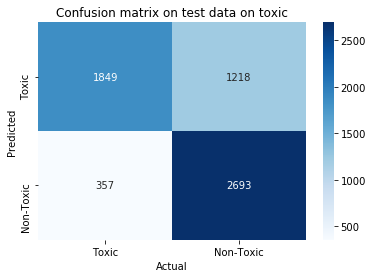

In [187]:
import seaborn as sns
cm = pd.DataFrame(confusion_matrix(y_test,y_pred_bool) , index = ['Toxic','Non-Toxic'] , columns = ['Toxic','Non-Toxic'])
sns.heatmap(cm,cmap= 'Blues', annot = True, fmt='', xticklabels = ['Toxic','Non-Toxic'], yticklabels = ['Toxic','Non-Toxic'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix on test data on toxic')
plt.show()

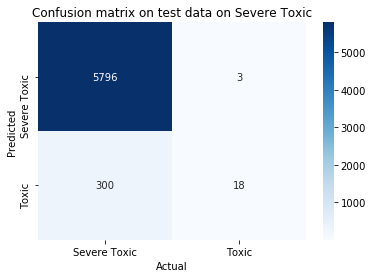

In [49]:
import seaborn as sns
cm = pd.DataFrame(confusion_matrix(y_test_1,y_pred_bool_1) , index = ['Severe Toxic','Toxic'] , columns = ['Severe Toxic','Toxic'])
sns.heatmap(cm,cmap= 'Blues', annot = True, fmt='', xticklabels = ['Severe Toxic','Toxic'], yticklabels = ['Severe Toxic','Toxic'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix on test data on Severe Toxic')
plt.show()

In [ ]:
#Predict On TEST.CSV

In [50]:
predict_data = list(df_test["cleaned_text"].values)
predict_data

['charge happy catch',
 'thanks clean wp wa issue',
 'people keen act upon whim put spoiler rather sad imagine want information tell character kill mean point people ruin others certain editor chip shoulder chance watch programme concern allow advise soap article lock important storyline upcoming people want dig future websites wikipedia become regurgitate form digital spy pathetic',
 'artist fake person shallow heartless quick turn others choose believe people friend help support say artist lot commission artist turn chose rude crude twat commission artist probably get black list spending much art choose believe another person lie beware frenemy',
 'come talk page hey bb come talk page redrafted suggestion early life aspect asma alassad confusion rectify know write early life slightly sloppy let know think go let apply change necessary',
 'bombay rum heard several people talk bombay rum apparently india can not find even much reference web exist call something else',
 'secure digital 

In [51]:
predict_data_pre = []
for row in predict_data:
    predict_new = news_sentences(row)
    predict_new = list(itertools.chain(*predict_new))
    predict_data_pre.append(predict_new)


In [52]:
#assign values for the words in each sentence in the training and test dataset using word2vec model
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}
predict_data_seq = [[word_index.get(t, 0) for t in sentence]
             for sentence in predict_data_pre]
# test_sequences = [[word_index.get(t, 0)  for t in sentence] 
#                   for sentence in X_test_sent_pre]

# pad the sequences
predict_data_seq = pad_sequences(predict_data_seq, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
# X_test_seq = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
#                           truncating="post")

In [53]:
predict_data_seq


array([[   0,    0,    0, ..., 1289,  375, 1426],
       [   0,    0,    0, ...,  532, 7757,  164],
       [   0,    0,    0, ..., 4548, 4248,  463],
       ...,
       [   0,    0,    0, ...,  317,  962,  575],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    3,  252,  996]])

In [54]:
predict_data_seq.shape

(13899, 200)

In [55]:
test_outputs = model.predict(predict_data_seq)

In [56]:
test_outputs[0]

array([0.0943096], dtype=float32)

In [57]:
test_outputs.shape

(13899, 1)

In [58]:
output_df = df_test.reset_index()[['id','cleaned_text','comment_text']].copy()

In [198]:
# y_1

In [60]:
df_target_train = df_train['severe_toxic'].values
df_target_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [62]:
target_class_train = df_train.columns[1:2]
target_class_train

Index(['severe_toxic'], dtype='object')

In [63]:
for i, target_class in enumerate(target_class_train):
    output_df[target_class] = test_outputs[:,i]

In [64]:
output_df

,id,cleaned_text,comment_text,severe_toxic
0,9bf33f071c9b3263,charge happy catch,""" \n : ) No charge. Happy I was there to catch...",0.094310
1,39663d63a79f841b,thanks clean wp wa issue,==Thanks== \n For cleaning up the wp in wa issue!,0.094310
2,2b8aa65b64094d44,people keen act upon whim put spoiler rather s...,Why are people keen to act upon their whims an...,0.001954
3,b21145e7025ea830,artist fake person shallow heartless quick tur...,This Artist is FAKE! \n\n * \n\n https://www...,0.002913
4,4c24b0fa5c3e0db0,come talk page hey bb come talk page redrafted...,""" \n\n == Come by the Talk Page == \n\n Hey Bb...",0.010889
...,...,...,...,...
13894,9b18410be1be57df,gay,it is so gay!!!!!!!,0.094310
13895,6ee0461dee335c37,isbn thanks fo rhe info idea copy usage page w...,==ISBN== \n Thanks fo rhe info. Had no idea. ...,0.034632
13896,062ad44640ce09ba,neutrality dispute add several statement clear...,== Neutrality disputed == \n I added to sever...,0.000171
13897,ccb0a3fc6168d4a5,usergert gert,"User:Gert7|Gert7]] 10:34,",0.094310


In [67]:
for i in range(len(output_df["severe_toxic"])):
    if output_df['severe_toxic'][i] >= 0.5:
        output_df["severe_toxic"][i] = 1
    else:
        output_df["severe_toxic"][i] = 0

output_df

C:\Users\z\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\z\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,cleaned_text,comment_text,severe_toxic
0,9bf33f071c9b3263,charge happy catch,""" \n : ) No charge. Happy I was there to catch...",0.0
1,39663d63a79f841b,thanks clean wp wa issue,==Thanks== \n For cleaning up the wp in wa issue!,0.0
2,2b8aa65b64094d44,people keen act upon whim put spoiler rather s...,Why are people keen to act upon their whims an...,0.0
3,b21145e7025ea830,artist fake person shallow heartless quick tur...,This Artist is FAKE! \n\n * \n\n https://www...,0.0
4,4c24b0fa5c3e0db0,come talk page hey bb come talk page redrafted...,""" \n\n == Come by the Talk Page == \n\n Hey Bb...",0.0
...,...,...,...,...
13894,9b18410be1be57df,gay,it is so gay!!!!!!!,0.0
13895,6ee0461dee335c37,isbn thanks fo rhe info idea copy usage page w...,==ISBN== \n Thanks fo rhe info. Had no idea. ...,0.0
13896,062ad44640ce09ba,neutrality dispute add several statement clear...,== Neutrality disputed == \n I added to sever...,0.0
13897,ccb0a3fc6168d4a5,usergert gert,"User:Gert7|Gert7]] 10:34,",0.0


In [68]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13899 entries, 0 to 13898
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            13899 non-null  object 
 1   cleaned_text  13899 non-null  object 
 2   comment_text  13899 non-null  object 
 3   severe_toxic  13899 non-null  float32
dtypes: float32(1), object(3)
memory usage: 380.2+ KB


In [69]:
output_df['severe_toxic'] = output_df['severe_toxic'].astype(int)
output_df

,id,cleaned_text,comment_text,severe_toxic
0,9bf33f071c9b3263,charge happy catch,""" \n : ) No charge. Happy I was there to catch...",0
1,39663d63a79f841b,thanks clean wp wa issue,==Thanks== \n For cleaning up the wp in wa issue!,0
2,2b8aa65b64094d44,people keen act upon whim put spoiler rather s...,Why are people keen to act upon their whims an...,0
3,b21145e7025ea830,artist fake person shallow heartless quick tur...,This Artist is FAKE! \n\n * \n\n https://www...,0
4,4c24b0fa5c3e0db0,come talk page hey bb come talk page redrafted...,""" \n\n == Come by the Talk Page == \n\n Hey Bb...",0
...,...,...,...,...
13894,9b18410be1be57df,gay,it is so gay!!!!!!!,0
13895,6ee0461dee335c37,isbn thanks fo rhe info idea copy usage page w...,==ISBN== \n Thanks fo rhe info. Had no idea. ...,0
13896,062ad44640ce09ba,neutrality dispute add several statement clear...,== Neutrality disputed == \n I added to sever...,0
13897,ccb0a3fc6168d4a5,usergert gert,"User:Gert7|Gert7]] 10:34,",0


In [70]:
count_non = (output_df['severe_toxic'] == 0).sum()
print("toxic count: " ,count_non)

count_toxic = (output_df['severe_toxic'] == 1).sum()
print("severe toxic count: " ,count_toxic)

toxic count:  13886
severe toxic count:  13


In [71]:
output_df.to_csv('severe_toxic_predicted.csv', index=False)

In [72]:
output_df.head()

,id,cleaned_text,comment_text,severe_toxic
0,9bf33f071c9b3263,charge happy catch,""" \n : ) No charge. Happy I was there to catch...",0
1,39663d63a79f841b,thanks clean wp wa issue,==Thanks== \n For cleaning up the wp in wa issue!,0
2,2b8aa65b64094d44,people keen act upon whim put spoiler rather s...,Why are people keen to act upon their whims an...,0
3,b21145e7025ea830,artist fake person shallow heartless quick tur...,This Artist is FAKE! \n\n * \n\n https://www...,0
4,4c24b0fa5c3e0db0,come talk page hey bb come talk page redrafted...,""" \n\n == Come by the Talk Page == \n\n Hey Bb...",0
